In [2]:
import xarray as xr
import numpy as np
import dask
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

In [3]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

In [4]:
def find_slopeloc(bath, epsilon=0.01):
    shelf_depth = np.min(bath)
    central_basin_depth = np.max(bath)
    upper_treshold = shelf_depth+epsilon*(central_basin_depth-shelf_depth)
    lower_treshold = central_basin_depth-epsilon*(central_basin_depth-shelf_depth)
    
    lx0 = next(x for x in bath if x < upper_treshold).y
    lx1 = next(x for x in bath if x < lower_treshold).y
    
    bath_r = bath.isel(y=slice(-1,0,-1))
    
    rx1 = next(x for x in bath_r if x < upper_treshold).y
    rx0 = next(x for x in bath_r if x < lower_treshold).y
    
    return lx0, lx1, rx0, rx1

In [5]:
rho = 1e3

In [22]:
case = "BLOM_channel_new02_mix1"
#case = "BLOM_channel_new05_mix1"
datapath = f"/home/alsjur/PhD/Kode/BLOM-channel-momentum/data/{case}/"

figurepath = f"/home/alsjur/PhD/Kode/BLOM-channel-momentum/figures/"

ds = xr.open_mfdataset(datapath+f"{case}_momentumterms_*.nc")#.isel(y=slice(1,-1))
bath = xr.open_dataarray(datapath+f"{case}_bathymetry.nc")#.isel(y=slice(1,-1))

In [23]:
ds

<xarray.Dataset> Size: 89MB
Dimensions:  (time: 5400, y: 512)
Coordinates:
  * time     (time) object 43kB 2020-01-01 12:00:00 ... 2034-12-30 12:00:00
  * y        (y) float64 4kB 0.0 2e+03 4e+03 ... 1.018e+06 1.02e+06 1.022e+06
Data variables:
    UV       (time, y) float32 11MB dask.array<chunksize=(30, 512), meta=np.ndarray>
    U        (time, y) float32 11MB dask.array<chunksize=(30, 512), meta=np.ndarray>
    fV       (time, y) float32 11MB dask.array<chunksize=(30, 512), meta=np.ndarray>
    dUdt     (time, y) float32 11MB dask.array<chunksize=(30, 512), meta=np.ndarray>
    phidhdx  (time, y) float32 11MB dask.array<chunksize=(30, 512), meta=np.ndarray>
    dUVdy    (time, y) float32 11MB dask.array<chunksize=(30, 512), meta=np.ndarray>
    tauxb    (time, y) float32 11MB dask.array<chunksize=(30, 512), meta=np.ndarray>
    ubar     (time, y) float32 11MB dask.array<chunksize=(30, 512), meta=np.ndarray>

In [24]:
ds_mean = ds.mean(dim="time")
ds_mean["h"] = bath.mean(dim="x")

AttributeError: 'Dataset' object has no attribute 'dUdt1'

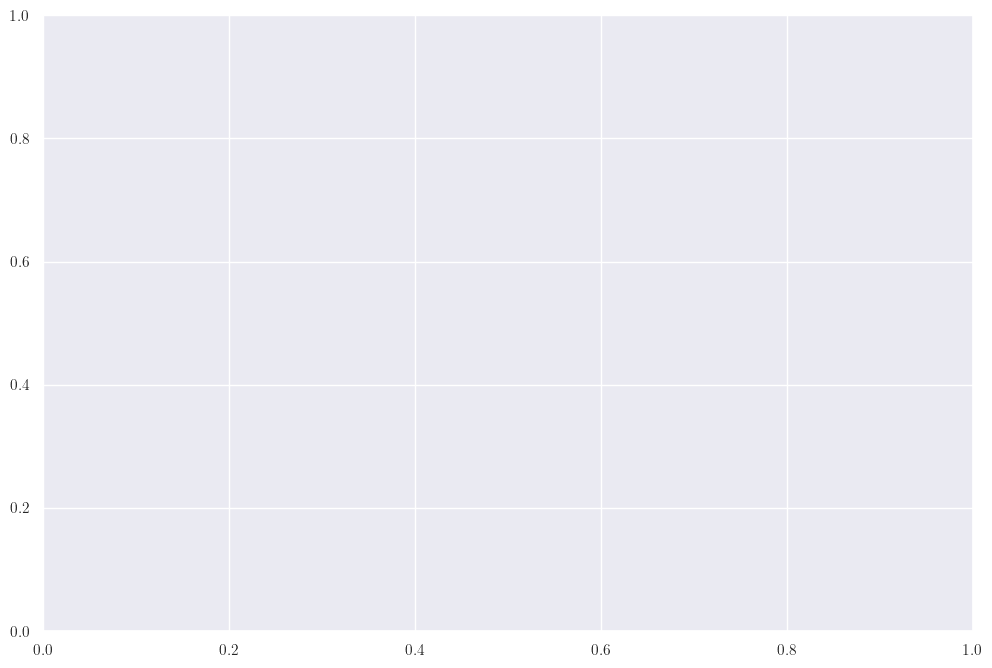

In [25]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(12,8))
y = ds_mean.y/1e3
surface_forcing = [-0.05/rho]*len(y.values) 
MFD = -ds_mean.dUVdy
TFS = -ds_mean.phidhdx
dUdt = ds_mean.dUdt1
fV = ds_mean.fV1
bottom_drag = -ds_mean.tauxb1
res = -dUdt+MFD+TFS+fV+bottom_drag+surface_forcing


ds_mean["residual"] = res




"""
ax2 = ax.twinx()
ax2.plot(y, bath_mean, alpha=0.2, color="gray", ls="--", zorder=100)
#ax2.set_ylabel("Depth [m]")
ax2.set_yticks([])
"""

ax.axhline(0, color="gray")

vars = [dUdt, MFD, fV, TFS, surface_forcing, bottom_drag, res]
labels = [r"$\frac{\partial}{\partial t}\overline{U}$", 
          r"$-\overline{\frac{\partial}{\partial y}\int_{-H}^0(uv)\,dz}$", 
          r"$+\overline{fV}$",
          r"$-\overline{\Phi_b\frac{\partial}{\partial x}h_b}$",
          r"$+\overline{\tau^x_s}$",
          r"$-\overline{\tau^x_b}$",
          "residual"
          ]

colors = mpl.colormaps['tab10'].resampled(len(vars)).colors

maxx = 0
for var, label, color in zip(vars, labels, colors):
    ax.plot(y, var, 
            label=label, 
            lw = 2,
            color=color
            )
    maxx = np.max([maxx, np.abs(var).max()])
    
scale = maxx/np.max(np.abs(ds_mean.ubar))
ax.plot(y, ds_mean.ubar*scale, 
         color="gray", 
         alpha=0.5,
         lw = 3,
         ls="--", 
         zorder=100,
         label=r"$\propto\overline{u}$"
         )    


lx0, lx1, rx0, rx1 = find_slopeloc(ds_mean.h, epsilon=0.01)
ax.axvspan(lx0/1e3, lx1/1e3, alpha=0.2, color="gray", label="slope")
ax.axvspan(rx0/1e3, rx1/1e3, alpha=0.2, color="gray")

ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
ax.set_ylabel("depth-integrated momentum [m²/s²]")
ax.set_xlabel("cross-channel position [km]")
ax.set_xlim(np.min(y), np.max(y))

#eq = r"$\frac{\partial}{\partial t}\overline{U} = - \overline{\frac{\partial}{\partial y}\int_{-H}^0(uv)\,dz} -\overline{\Phi_b\frac{\partial}{\partial x}h_b} + \overline{\tau^x_s}-\overline{\tau^x_b}$"
eq = labels[0]+"="
for term in labels[1:-1]:
    eq+=term
ax.set_title(eq+"\n", fontsize=18)

plt.tight_layout()
fig.savefig(figurepath+f"{case}_momentumTerms.png")

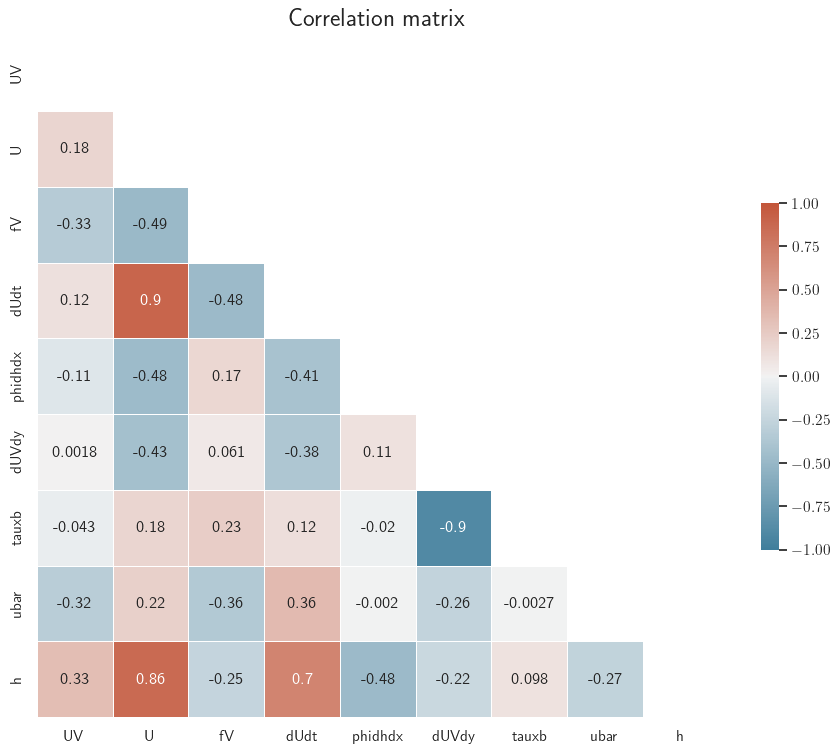

In [26]:
d = ds_mean.squeeze().to_pandas().drop("time", axis=1)

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, vmin=-1, vmax=1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

ax.set_title("Correlation matrix", fontsize=18)
fig.savefig(figurepath+f"{case}_correlationMatrix.png")